<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 4
</div>

<hr>

### Overview

This task sheet addresses region segmentation using clustering and superpixels. The main idea behind clustering is to partition all pixels into a specified number of clusters. In $k$-means clustering, as discussed in task 4.1, each pixel is assigned to the cluster with the nearest mean. The means are often called *prototypes*, as they are the reference values for each cluster. The algorithm refines the clustering in an iterative manner.

Task 4.2 addresses superpixels. The idea is to replace the standard pixel grid by primitive regions that are perceptually meaningful. By this means, the number of units which have to be processed in further steps (such as object recognition) can be significantly reduced.


---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 4.1</span> $k$-Means Clustering

The algorithm works in an iterative manner and assigns each pixel to one cluster. In each iteration, it refines the means (prototypes) of each cluster until convergence. In a simple form, the algorithm can be summarized as follows:

**Required**: Number of clusters $k$.

1. Initialize the algorithm: Specify an initial set of $k$ means (prototypes) $\mathbf{m}_i, i=1, 2, \dots, k$ (manually, by chance, using an algorithm).
2. Assign samples to clusters: Assign each sample (pixel) to the cluster $i$ with the closest mean $\mathbf{m}_i$.
3. Update the cluster centers: Update the means $\mathbf{m}_i$ based on the samples (pixels) in each cluster.
4. Completion test: If there are (nearly) no further reassignments (the means do not change), stop the process, otherwise go back to step 2.

Implement / solve the following tasks:
1. Read a test image as a grayscale image and plot it.
2. Create a NumPy array with an initial set of means.
3. Implement steps 1-3 and plot the results.
4. Implement step 4 by integrating the previous steps into an appropriate while loop (compare the previous and last means).
5. Test the algorithm with different test images and parameters.

Input image:


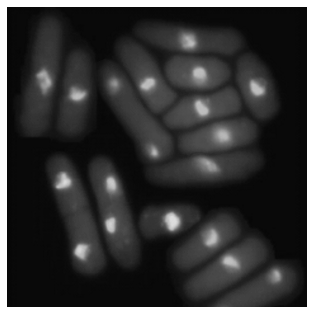

Iteration 1:
means_last = 	[ 50 100 150]
means = 	[ 28  91 162]
---
Iteration 2:
means_last = 	[ 28  91 162]
means = 	[ 23  75 163]
---
Iteration 3:
means_last = 	[ 23  75 163]
means = 	[ 18  66 158]
---
Iteration 4:
means_last = 	[ 18  66 158]
means = 	[ 15  61 153]
---
Iteration 5:
means_last = 	[ 15  61 153]
means = 	[ 14  59 150]
---
Iteration 6:
means_last = 	[ 14  59 150]
means = 	[ 13  58 148]
---
Iteration 7:
means_last = 	[ 13  58 148]
means = 	[ 13  57 147]
---
Iteration 8:
means_last = 	[ 13  57 147]
means = 	[ 13  57 146]
---
Iteration 9:
means_last = 	[ 13  57 146]
means = 	[ 13  57 145]
---
Iteration 10:
means_last = 	[ 13  57 145]
means = 	[ 13  57 145]
---
Segmentation result:


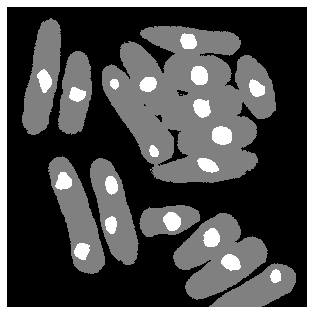

In [2]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/cells.png', 0)
rows, cols = img.shape
print("Input image:")
plot_img_orig(img)

# initial set of k means (number of means provided here specifies k)
means = np.array([50, 100, 150]) # manually, by chance, or algorithm

# assign samples (pixels) to clusters based on their gray-value
labels = (-1)*np.ones(img.shape, dtype=np.int64) # image with labels, init with -1

# repeat process until means do not change anymore
means_last = (-1)*means.copy()
cnt = 0 # count the number of iterations

#for m in range(20): # testing
while not (means_last == means).all():
    # increase iteration counter
    cnt += 1
    
    # save last means for comparison
    means_last = means.copy()
    
    # iterate over all pixels
    for i in range(rows):
        for j in range(cols):
            # compute distance to all means
            d_min = np.inf # init (inf = infinity)

            for k in range(len(means)):
                d = np.linalg.norm(means[k]-img[i, j]) # euclidean distance

                # assign label to mean with smallest distance
                if (d < d_min):
                    d_min = d
                    labels[i, j] = k # first label is 0

    # update the cluster centers (means)
    for k in range(len(means)):
        cluster = img[np.nonzero(labels == k)]
        
        if cluster.size > 0: # otherwise just leave mean unchanged
            means[k] = np.mean(cluster)
        
    # print mean values for each iteration
    print("Iteration " + str(cnt) + ":")
    print("means_last = \t" + str(means_last))
    print("means = \t" + str(means))
    print("---")

# plot of the normalized label image
labels_n = cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX)
print("Segmentation result:")
plot_img_orig(labels_n)

#### <span style="color: RoyalBlue; font-weight: bold;">Task 4.2</span> Simple Linear Iterative Clustering (SLIC)

The algorithm has been developed by <a href="https://core.ac.uk/download/pdf/147983593.pdf">Achanta et al. (2012)</a>, is conceptually simple, and has a good overall performance. The algorithm is a modification of $k$-means clustering. SLIC typically uses 5-dimensional feature vectors $\mathbf{z}$ for each input pixel: three color values and two spatial coordinates. For simplicity, this example uses grayscale images and 3-dimensional feature vectors: one gray value $f$ and two spatial coordinates:

$$\mathbf{z} = [f\ x\ y]^T$$

Note that $k$-means clustering uses the gray value distance only, while SLIC also uses the spatial distance to the prototype. Initial superpixel centers $\mathbf{m}_i = [f_i\ x_i\ y_i]^T$ are obtained by sampling the image on a regular grid spaced $s = \sqrt{n_{tp} / n_{sp}}$ pixels apart. Here, $n_{tp}$ is the total number of pixels and $n_{sp}$ the desired number of superpixels. In a simple form, the algorithm can be summarized as follows:

**Required**: Desired number of superpixels $n_{sp}$.

1. Initialize the algorithm: Compute the initial mean (prototype) vectors $\mathbf{m}_i$. For better stability (avoid edges and noise), the centers can be moved to the lowest gradient position in a $3\times 3$ neighborhood (this step is skipped in this example). Initialize an additional label image as $L(x,y) = -1$ and a distance image as $d(x,y)=\infty$.
2. Assign samples to each cluster: For each $\mathbf{m}_i$, compute the distance $D_i$ (see below) between $\mathbf{m}_i$ and each pixel $p$ in a $2s \times 2s$ neighborhood around $\mathbf{m}_i$. If $D_i < d(p)$, let $d(p) = D_i$ and $L(p) = i$ (assign $p$ to the superpixel with the closest mean $\mathbf{m}_i$).
3. Update the cluster centers: Update the means $\mathbf{m}_i$ based on the samples (pixels) in each cluster.
4. Test for convergence: Stop the process if the Euclidean distance between the previous and last mean vector is below a threshold.
5. Post-processing: Replace all superpixels of each cluster by their mean gray value.

The following formular can be used to compute the distance:

$$D = \left[ d_c^2 + \left( \dfrac{d_s}{s} \right)^2 c^2 \right]^{1/2}$$

In this equation, $c$ is a constant to weight the relative importance between similarity and spatial proximity. The distances $d_c$ and $d_s$ are the gray value distance and the spatial Euclidean distance, respectively. In principal, the formular combines the normalized distances. The normalization is required because the gray values and coordinates have different scales and are unrelated.

Implement / solve the following tasks:
1. Read a test image as a grayscale image and plot it.
2. Implement steps 1-3 and plot the results.
3. Implement step 4 by integrating the previous steps into an appropriate while loop (check the distance between the previous and last mean vectors).
4. Implement the post-processing and draw borders around each superpixel.
5. Test the algorithm with different test images and parameters.

Input image:


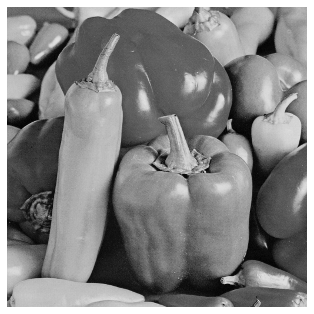

Initial cluster centers:


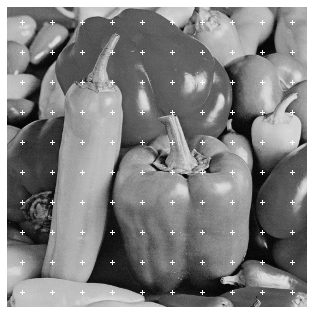

2s x 2s neighborhoods (superimposed):


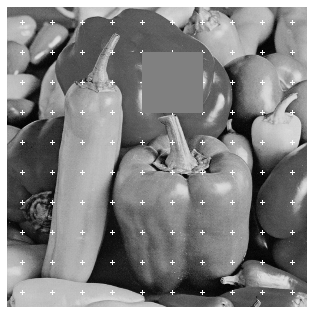

Iteration 1:
Mean vector distance = 144.0774736640713
---
Iteration 2:
Mean vector distance = 27.835320105097058
---
Iteration 3:
Mean vector distance = 11.713134381772374
---
Iteration 4:
Mean vector distance = 5.353660675291744
---
Labels:


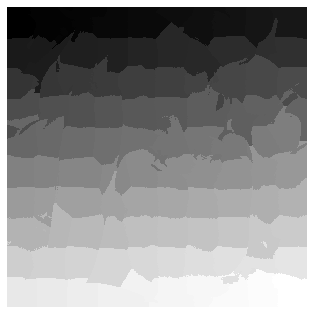

Resulting superpixels:


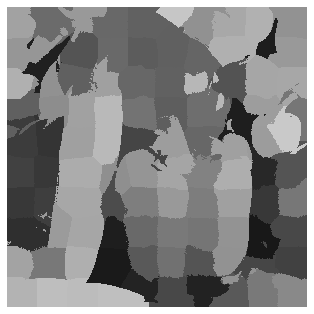

Resulting superpixels with borders:


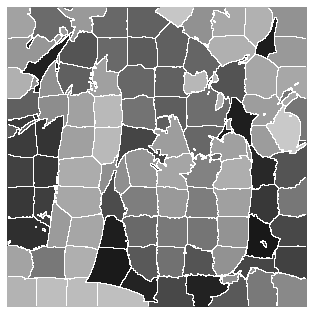

In [3]:
# write your code here

# read the image as a grayscale image (parameter 0) and plot it
img = cv2.imread('images/peppers-small.png', 0)
rows, cols = img.shape
print("Input image:")
plot_img_orig(img)

# parameters
n_sp = 100 # number of superpixels (use squares for square images)
c = 100 # relative importance between similarity and spatial proximity
threshold = 10 # mean value distance for convergence

# initialize means
means = np.zeros((n_sp, 3)) # structure of each mean: (gray value, x, y)

# initialize label image and distance images
labels = (-1)*np.ones(img.shape, dtype=np.int64) # image with labels, init with -1
distances = np.inf*np.ones(img.shape)

# compute grid spacing interval s
s = int(np.sqrt(img.size / n_sp))

# compute center coordinates of each cluster
x_c = np.arange(int(s/2), rows, s)
y_c = np.arange(int(s/2), cols, s)

# initialize means
img_c = img.copy() # visualization: draw center points of clusters
for i in range(len(x_c)):
    for j in range(len(y_c)):
        idx = j + len(y_c)*i # index (current iteration number)
        means[idx] = (img[x_c[i], y_c[j]], x_c[i], y_c[j])

        cv2.drawMarker(img_c, (x_c[i], y_c[j]), 255, 0, 5) # visualization

print("Initial cluster centers:")
plot_img_orig(img_c)

# repeat process until means become similar
means_last = (-1)*means.copy()
cnt = 0 # count the number of iterations

#for m in range(1): # testing
while (np.linalg.norm(means-means_last) > threshold):
    # increase iteration counter
    cnt += 1
    
    # save last means for comparison
    means_last = means.copy()

    # assign samples (pixels) to cluster centers
    for k in range(len(means)):
        # get current cluster center
        x_ck = int(means[k, 1]) # get current center x coordinate (row)
        y_ck = int(means[k, 2]) # get current center y coordinate (column)

        # compute slice coordinates of 2s x 2s neighborhood about each m
        rows_k = np.arange(x_ck-s, x_ck+(s+2))
        cols_k = np.arange(y_ck-s, y_ck+(s+2))

        # remove elements outside the image
        rows_k = rows_k[np.nonzero((rows_k >= 0) & (rows_k <= rows))] # last element is excluded in next step
        cols_k = cols_k[np.nonzero((cols_k >= 0) & (cols_k <= cols))]

        # visualization: check if clusters are correct
        if k == 25 and cnt == 1:
            img_c[rows_k[0]:rows_k[-1], cols_k[0]:cols_k[-1]] = 128
            print("2s x 2s neighborhoods (superimposed):")
            plot_img_orig(cv2.normalize(img_c, None, 0, 255, cv2.NORM_MINMAX))

        # compute distance between m_i and each pixel in 2s x 2s neighborhood
        for i in range(rows_k[0], rows_k[-1]):
            for j in range(cols_k[0], cols_k[-1]):
                d_c = np.linalg.norm(means[k, 0]-img[i, j]) # gray value distance
                d_s = np.sqrt((means[k, 1]-i)*(means[k, 1]-i) + (means[k, 2]-j)*(means[k, 2]-j)) # spatial euclidean distance

                d = np.sqrt(d_c*d_c + (d_s/s)*(d_s/s)*c*c)

                # compare with distance image
                if d < distances[i, j]:
                    distances[i, j] = d
                    labels[i, j] = k

    # update the cluster centers (means)
    for k in range(len(means)):
        cluster_coordinates = np.nonzero(labels == k)
        cluster = img[cluster_coordinates]

        if cluster.size > 0: # otherwise just leave means unchanged 
            means[k, 0] = np.mean(cluster) # mean of intensity values
            means[k, 1] = np.mean(cluster_coordinates[0]) # mean of row coordinates
            means[k, 2] = np.mean(cluster_coordinates[1]) # mean of col coordinates

    # print mean value distance for each iteration
    print("Iteration " + str(cnt) + ":")
    print("Mean vector distance = " + str(np.linalg.norm(means-means_last)))
    print("---")

# plot of the label image
print("Labels:")
plot_img_orig(cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX))

# post-processing: replace superpixels by their mean value
res = np.zeros(img.shape, dtype=np.int64)

for k in range(len(means)):
    cluster_coordinates = np.nonzero(labels == k)
    res[cluster_coordinates] = means[k, 0]

print("Resulting superpixels:")
plot_img_orig(res)

res_borders = res.copy()

# overlay superpixel borders
for i in range(1, rows-1):
    for j in range(1, cols-1):
        l = labels[i, j] # check current label
        
        # the difference is zero for identical labels
        if (l-labels[i, j+1]) != 0 or \
            (l-labels[i+1, j+1]) != 0 or \
            (l-labels[i+1, j]) != 0:
            
                # superpixel border found
                res_borders[i, j] = 255
                
print("Resulting superpixels with borders:")
plot_img_orig(res_borders)